In this notebook, I will be attempting the Natural Language Processing with Disaster Tweets Kaggle competition (https://www.kaggle.com/c/nlp-getting-started). In it, we have to classify tweets based on whether or not they correspond to an actual disaster. The project will be available at https://github.com/giosofteng/nlpwdt .

Let us begin by importing and inspecting the relevant data:

In [1]:
import pandas as pd
# improve print formatting
pd.set_option('display.expand_frame_repr', False)

# import data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# inspect train data
print(f'\nTRAIN DATA INFO:')
df_train.info()
print(f'\nTRAIN DATA SHAPE: {df_train.shape}\n')
print(f'FIRST 5 ROWS:\n{df_train.head()}\n\n')

# inspect test data
print('TEST DATA INFO:')
df_test.info()
print(f'\nTEST DATA SHAPE: {df_test.shape}\n')
print(f'FIRST 5 ROWS:\n{df_test.head()}\n')


TRAIN DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

TRAIN DATA SHAPE: (7613, 5)

FIRST 5 ROWS:
   id keyword location                                               text  target
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...       1
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada       1
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...       1
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...       1
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...       1


TEST DATA INFO:
<cla

Let us now do some basic data cleaning to ready everything for further analysis:

In [2]:
# check missing vals
print(f'\nTRAIN DATA MISSING VALS:\n{df_train.isnull().sum()}')
print(f'\nTEST DATA MISSING VALS:\n{df_test.isnull().sum()}\n')


TRAIN DATA MISSING VALS:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

TEST DATA MISSING VALS:
id             0
keyword       26
location    1105
text           0
dtype: int64



Since we have a lot of entries with missing keyword and location vals, instead of dropping them, let us fill in these fields with “unknown”. After all, the contents of the tweets themselves ought to be more important indicators.

In [3]:
# replace missing vals with `unknown`
df_train['keyword'] = df_train['keyword'].fillna('unknown')
df_train['location'] = df_train['location'].fillna('unknown')
df_test['keyword'] = df_test['keyword'].fillna('unknown')
df_test['location'] = df_test['location'].fillna('unknown')

# validate changes
print(f'\nTRAIN DATA MISSING VALS:\n{df_train.isnull().sum()}')
print(f'\nTEST DATA MISSING VALS:\n{df_test.isnull().sum()}\n')


TRAIN DATA MISSING VALS:
id          0
keyword     0
location    0
text        0
target      0
dtype: int64

TEST DATA MISSING VALS:
id          0
keyword     0
location    0
text        0
dtype: int64



Before moving on to the EDA, let us also drop any duplicate rows, based on the “text” column (the one for actual tweets).

In [4]:
df_train = df_train.drop_duplicates(subset=['text']).reset_index(drop=True)

Now, let us visualize the “target” column distribution to make sure that our data is balanced enough:

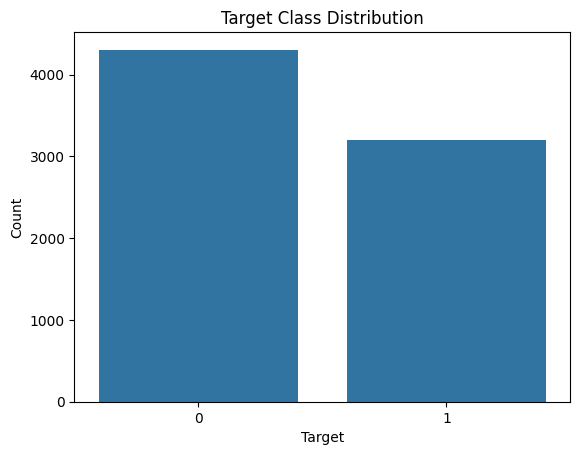

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='target', data=df_train)
plt.title('Target Class Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

It seems that most of our tweets are of non-disaster variety. Still, we have plenty of samples for both categories.

Let us also display top 10 keywords and locations, while we are at it:

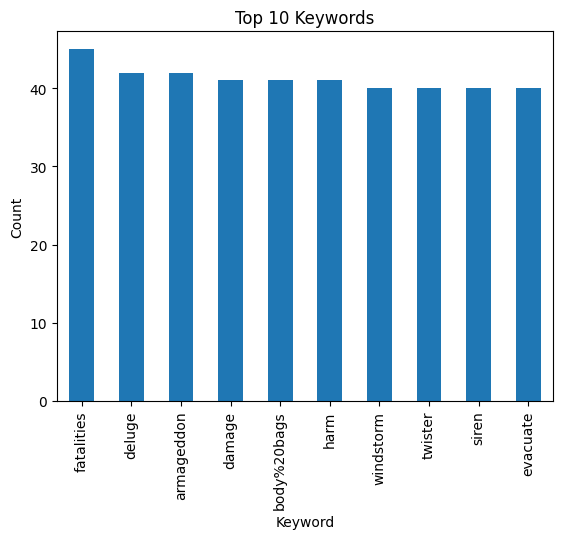

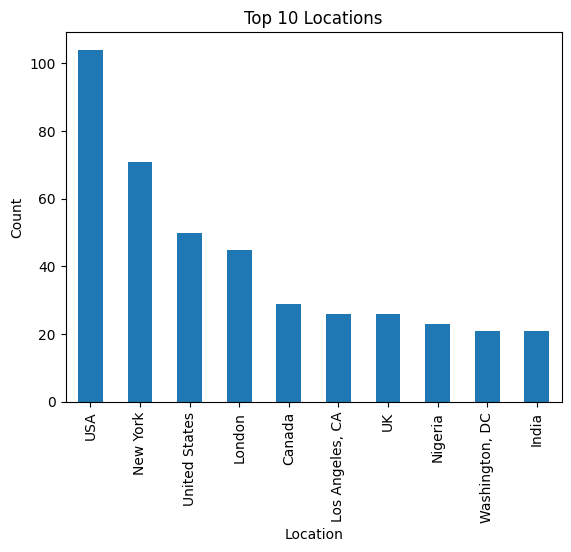

In [6]:
df_train[df_train['keyword'] != 'unknown']['keyword'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Keywords')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.show()

df_train[df_train['location'] != 'unknown']['location'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

Very interesting! Lastly, let us do some basic pre-processing on the tweet contents to aid our future model.

In [7]:
import re

def clean_text(text):
    # make text lowercase
    text = text.lower()
    # remove numbers and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    return text

# clean `text` column & add it as `text_clean` column
df_train['text_clean'] = df_train['text'].apply(clean_text)
df_test['text_clean'] = df_test['text'].apply(clean_text)

# check changes
print(f'\n{df_train.head()}\n\n')
print(f'\n{df_test.head()}\n')


   id  keyword location                                               text  target                                         text_clean
0   1  unknown  unknown  Our Deeds are the Reason of this #earthquake M...       1  our deeds are the reason of this earthquake ma...
1   4  unknown  unknown             Forest fire near La Ronge Sask. Canada       1              forest fire near la ronge sask canada
2   5  unknown  unknown  All residents asked to 'shelter in place' are ...       1  all residents asked to shelter in place are be...
3   6  unknown  unknown  13,000 people receive #wildfires evacuation or...       1   people receive wildfires evacuation orders in...
4   7  unknown  unknown  Just got sent this photo from Ruby #Alaska as ...       1  just got sent this photo from ruby alaska as s...



   id  keyword location                                               text                                         text_clean
0   0  unknown  unknown                 Just happened a terrible c

Before doing anything else, since our test data lacks labels, let us split our train data (80/20) into train and validate (val) sets:

In [8]:
from sklearn.model_selection import train_test_split

# feature
X = df_train['text_clean']
# target
y = df_train['target']

# split train data into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

Now, let us do some more pre-processing on our text data—ready it for model training. This will involve tokenizing said text and padding the sequences to get uniform size input.

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenize text--consider at most 10,000 words
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
# pad sequences--make max length 100
X_train_seq = pad_sequences(X_train_seq, maxlen=100)
X_val_seq = pad_sequences(X_val_seq, maxlen=100)

# convert target labels to np arrays
y_train = y_train.values
y_val = y_val.values

Next, let us build a simple LSTM model. We will begin with an embedding layer, converting our text sequences into vectors and capturing word relationships. Then, we will place 2 LSTM layers capable of learning learning long-term dependencies. Placed between these, the dropout layers will help with overfitting. Since we are dealing with binary classification, the output layer will use a sigmoid function. Such a model will be able to capture the intricacies of human languages despite the noisy input data. It will also be relatively computationally efficient.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM

# init model
model = Sequential()
# add input layer
model.add(Input((100,)))
# add embedding layer: consider max 10,000 words & have vectors with 100 dimensions
model.add(Embedding(input_dim=10000, output_dim=100))
# add 1st LSTM layer of size 64
model.add(LSTM(64, return_sequences=True))
# add dropout layer
model.add(Dropout(0.5))
# add 2nd LSTM layer of size 32
model.add(LSTM(32))
# add another dropout layer
model.add(Dropout(0.5))
# add output layer
model.add(Dense(1, activation='sigmoid'))

# compile model and print summary
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,054,689 (4.02 MB)

 Trainable params: 1,054,689 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

Let us now train and evaluate this model:

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# train model with early stopping
model.fit(
    X_train_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

# evaluate model
loss, accuracy = model.evaluate(X_val_seq, y_val)
print(f'VALIDATION LOSS: {loss:.2f}')
print(f'VALIDATION ACCURACY: {accuracy:.2f}')

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6390 - loss: 0.6250 - val_accuracy: 0.7921 - val_loss: 0.4653
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8601 - loss: 0.3431 - val_accuracy: 0.7901 - val_loss: 0.4692
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9248 - loss: 0.2206 - val_accuracy: 0.7875 - val_loss: 0.5164
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9498 - loss: 0.1542 - val_accuracy: 0.7735 - val_loss: 0.6839
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9674 - loss: 0.1092 - val_accuracy: 0.7815 - val_loss: 0.7199
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9712 - loss: 0.0922 - val_accuracy: 0.7748 - val_loss: 0.8141
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7973 - loss: 0.4634
VALIDATION LOSS: 0.47
VALIDATION ACCURACY: 0.79


Not bad! Let us run it again with slower and faster learning rates to see if they change the results in any significant ways.

The default learning rate is 0.001. Let us try 0.01 instead:

In [12]:
from tensorflow.keras.optimizers import Adam

# re-compile model with 10x faster learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# re-fit and re-evaluate
model.fit(
    X_train_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)
loss, accuracy = model.evaluate(X_val_seq, y_val)
print(f'VALIDATION LOSS: {loss:.2f}')
print(f'VALIDATION ACCURACY: {accuracy:.2f}')

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7543 - loss: 0.5697 - val_accuracy: 0.7961 - val_loss: 0.4651
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9035 - loss: 0.2741 - val_accuracy: 0.7801 - val_loss: 0.5524
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9371 - loss: 0.1767 - val_accuracy: 0.7648 - val_loss: 0.6090
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9516 - loss: 0.1287 - val_accuracy: 0.7602 - val_loss: 0.8609
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9669 - loss: 0.0937 - val_accuracy: 0.7528 - val_loss: 1.0138
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9725 - loss: 0.0613 - val_accuracy: 0.7582 - val_loss: 1.1080
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7982 - loss: 0.4657
VALIDATION LOSS: 0.47
VALIDATION ACCURACY: 0.80


Now let us try 0.0001 (10x slower) instead:

In [13]:
# re-compile model with 10x slower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# re-fit and re-evaluate
model.fit(
    X_train_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)
loss, accuracy = model.evaluate(X_val_seq, y_val)
print(f'VALIDATION LOSS: {loss:.2f}')
print(f'VALIDATION ACCURACY: {accuracy:.2f}')

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9081 - loss: 0.2728 - val_accuracy: 0.7961 - val_loss: 0.4869
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9150 - loss: 0.2397 - val_accuracy: 0.7961 - val_loss: 0.5034
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9126 - loss: 0.2466 - val_accuracy: 0.7981 - val_loss: 0.5140
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9238 - loss: 0.2149 - val_accuracy: 0.7968 - val_loss: 0.5221
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9267 - loss: 0.2236 - val_accuracy: 0.7961 - val_loss: 0.5268
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7964 - loss: 0.4885
VALIDATION LOSS: 0.49
VALIDATION ACCURACY: 0.80


Seeing how the learning rate adjustments do not yield much different results, let us try a different architecture instead.

Our potentially better model will be a bidirectional LSTM, capable of learning from both past and future contexts. Let us build and evaluate it in the following cell:

In [14]:
from tensorflow.keras.layers import Bidirectional

bidirectional_model = Sequential()
# add input layer
bidirectional_model.add(Input((100,)))
# add embedding layer with same params as before
bidirectional_model.add(Embedding(input_dim=10000, output_dim=100))
# add bidirectional LSTM layer
bidirectional_model.add(Bidirectional(LSTM(64, return_sequences=True)))
# add dropout layer
bidirectional_model.add(Dropout(0.5))
# add 2nd bidirectional LSTM layer
bidirectional_model.add(Bidirectional(LSTM(32)))
# add 2nd dropout layer
bidirectional_model.add(Dropout(0.5))
# add output layer
bidirectional_model.add(Dense(1, activation='sigmoid'))

# compile model and print summary
bidirectional_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
bidirectional_model.summary()

# fit and evaluate
bidirectional_model.fit(
    X_train_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)
loss, accuracy = bidirectional_model.evaluate(X_val_seq, y_val)
print(f'VALIDATION LOSS: {loss:.2f}')
print(f'VALIDATION ACCURACY: {accuracy:.2f}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,761 (4.29 MB)

 Trainable params: 1,125,761 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.6371 - loss: 0.6216 - val_accuracy: 0.7928 - val_loss: 0.4672
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8717 - loss: 0.3334 - val_accuracy: 0.7908 - val_loss: 0.4696
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9305 - loss: 0.2124 - val_accuracy: 0.7788 - val_loss: 0.5360
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9528 - loss: 0.1536 - val_accuracy: 0.7702 - val_loss: 0.6406
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9705 - loss: 0.1055 - val_accuracy: 0.7495 - val_loss: 0.7441
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7942 - loss: 0.4630
VALIDATION LOSS: 0.47
VALIDATION ACCURACY: 0.79


We got roughly the same results! Let us summarize:

We attempted to classify tweets according to whether or not they were related to disasters. We imported, cleaned, and visualized the provided train and test data. During the cleaning, we filled in some missing values (which we did not end up needing), removed any duplicate rows, and did some preliminary text pre-processing (made all text lowercase, removed numbers, special characters, and URLs). Since our test data does not contain target labels, we split train data into train and val sets (typical 80/20 split). We then tokenized the cleaned text and converted it to uniform length sequences. Next we created two kinds of LSTM models—simple and bidirectional, both of which yielded roughly the same (good) results. We also experimented with different learning rates, which also did not yield any significant changes. Overall, I am quite happy with results. Although, to improve the accuracy further, I believe that we ought to try other (non-LSTM) models instead!

The following code allows us to submit our results to Kaggle. Our public score ended up being **0.79037**!

In [15]:
X_test_seq = tokenizer.texts_to_sequences(df_test['text_clean'])
X_test_seq = pad_sequences(X_test_seq, maxlen=100)

preds = (bidirectional_model.predict(X_test_seq) > 0.5).astype(int)
submission = pd.DataFrame({
    'id': df_test['id'],
    'target': preds.flatten()
})
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
